# Results

## Data Loading

In [1]:
suppressWarnings(suppressMessages(library("tidyverse")))
suppressWarnings(suppressMessages(library("ggpubr")))
suppressWarnings(suppressMessages(library("rstatix")))

library(tidyverse)
library(ggpubr)
library(rstatix)


map_abb <- list("df_gm"= "DF+ǴM", "gm"= "GM")

all_results <- c()

df_eval <- list("crossval"= data.frame(), "test"= data.frame())


for (evaluation in names(df_eval)){
    for (mod in names(map_abb)){

      filename <- sprintf("%s_%s.csv", mod, evaluation)
      path_col <- file.path(getwd(), "..", "..", "..", "resources", filename)
      
      df_mod <- read.csv(path_col)
      df_mod$fusion <- map_abb[[mod]]

      df_eval[[evaluation]] <- rbind(df_eval[[evaluation]], df_mod)
    }
}
df_val <- df_eval[["crossval"]]
df_test <- df_eval[["test"]]

#### Validation data

In [2]:
head(df_val)

fold r2        MAE      fusion
1 0    0.8026467 5.740682 DF+ǴM 
2 1    0.7473344 6.313860 DF+ǴM 
3 2    0.7362875 5.625505 DF+ǴM 
4 3    0.7456859 5.830985 DF+ǴM 
5 4    0.7941903 5.643035 DF+ǴM 
6 5    0.7565052 5.573205 DF+ǴM

In [3]:
aggregate(df_val[,c("r2", "MAE")], list(df_val$fusion), mean)

Group.1 r2        MAE     
1 DF+ǴM   0.7884606 5.548079
2 GM      0.7508428 6.140916

#### Test data

In [4]:
head(df_test)

subjectID gender age   y_hat    fusion
1 sub-474   1      34.01 40.33901 DF+ǴM 
2 sub-292   1      23.73 31.65292 DF+ǴM 
3 sub-382   1      65.91 46.45294 DF+ǴM 
4 sub-434   1      67.24 56.62014 DF+ǴM 
5 sub-395   0      45.03 35.61988 DF+ǴM 
6 sub-306   1      30.18 39.87024 DF+ǴM

In [5]:
df_test["abs_diff"] <- abs(df_test$y_hat - df_test$age)

result_mean <- aggregate(df_test[,c("age", "y_hat", "abs_diff")], list(df_test$fusion), mean)
result_mean

Group.1 age      y_hat    abs_diff
1 DF+ǴM   42.37309 45.59776 6.896464
2 GM      42.37309 45.49686 7.956941

## Statistics

### Paired t-test

.y. group1 group2 n1 n2 statistic df p     p.adj p.adj.signif
1 MAE DF+ǴM  GM     30 30 -1.828452 29 0.039 0.039 *

Warning message in if (fill %in% names(data) & is.null(add.params$fill)) add.params$fill <- fill:
“the condition has length > 1 and only the first element will be used”


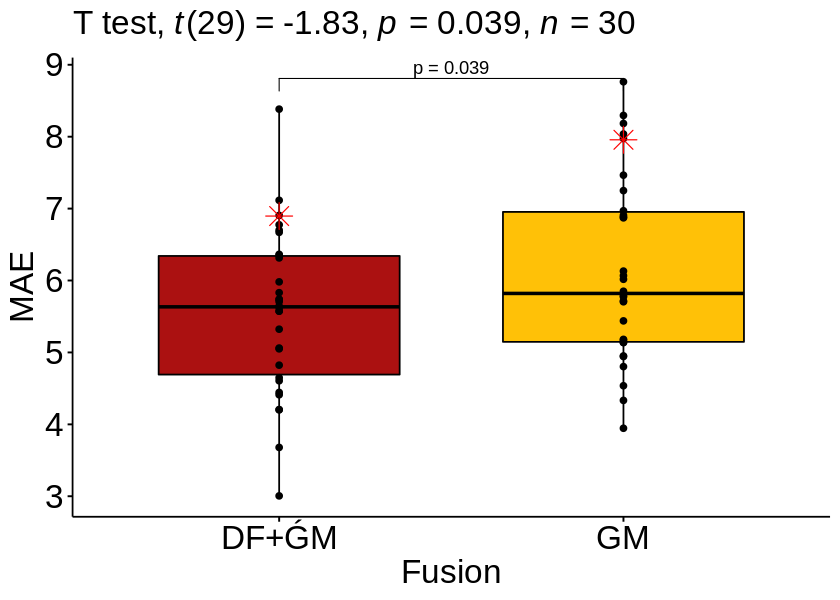

In [6]:

colors <- c("#AB1111", "#FFC107")

pwc <- df_val %>%
  pairwise_t_test(
    MAE ~ fusion, paired = TRUE, alternative="less"
  )
pwc

options(repr.plot.width = 7, repr.plot.height = 5)

bxp <- ggboxplot(df_val, x = "fusion", y = "MAE", add = "point", fill = colors,
                 xlab = "Fusion", ylab = "MAE") + theme(text = element_text(size=20))


pwc <- pwc %>% add_xy_position(x = "fusion")
bxp <- bxp + 
  stat_pvalue_manual(pwc, label = "p = {p.adj}") +
  labs(
    subtitle = get_test_label(pwc, detailed = TRUE),
  ) + geom_point(data = data.frame(x = factor(result_mean[["Group.1"]]), y = result_mean[["abs_diff"]]),
                   aes(x=x, y=y),
                   color = 'red', shape=8, size=5)

bxp 